# Image Classification

In [1]:
# Copyright 2022 Victor I. Afolabi
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     http://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import os
import pathlib

import PIL
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Download dataset

In [3]:
DATASET_URL = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
SUNFLOWER_URL = 'https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg'
TF_LITE_MODEL_PATH = '../saved_models/flower-classifier.tflite'

IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL = 512, 512, 3
EPOCHS, BATCH_SIZE, LEARNING_RATE = 15, 32, 1e-3
BUFFER_SIZE, FIG_SIZE = 1000, (10, 10)

In [4]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    origin=DATASET_URL,
    untar=True
)
data_dir = pathlib.Path(data_dir)

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'{image_count = :,}')

image_count = 3,670


### Visualize images

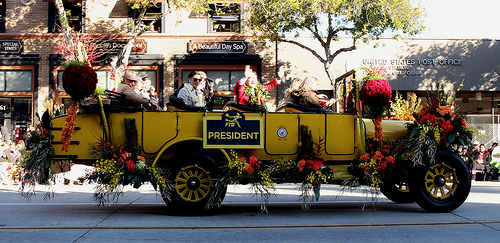

In [6]:
# Roses
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

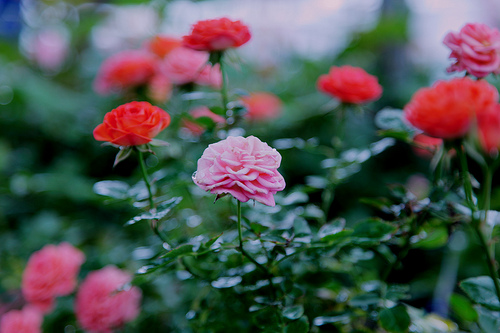

In [7]:
PIL.Image.open(str(roses[1]))

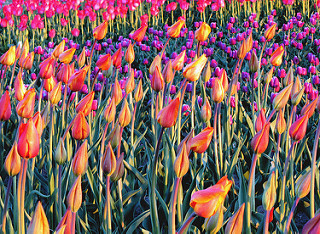

In [8]:
# Tulips
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

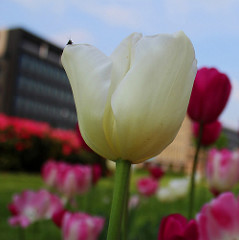

In [9]:
PIL.Image.open(str(tulips[1]))

## Load data with Keras

In [10]:
data_dir

PosixPath('/Users/victor/.keras/datasets/flower_photos')

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Metal device set to: Apple M1


2022-09-14 23:03:34.307996: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-14 23:03:34.308134: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
# Class names
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the data

2022-09-14 23:03:34.414524: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


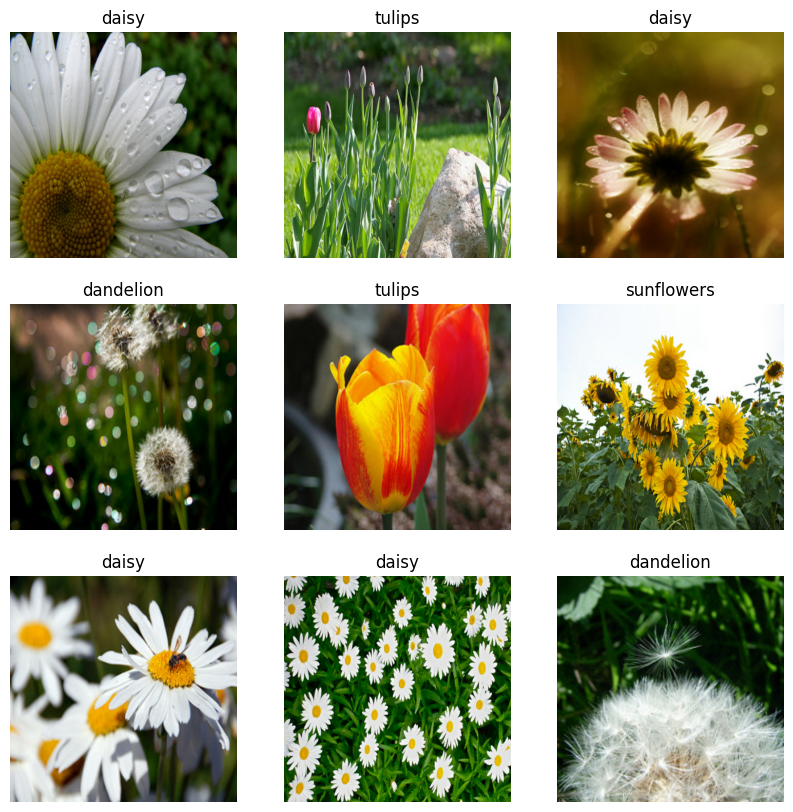

In [14]:
plt.figure(figsize=FIG_SIZE)

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [15]:
for image_batch, label_batch in train_ds:
    print(f'{image_batch.shape = }')
    print(f'{label_batch.shape = }')
    break

image_batch.shape = TensorShape([32, 512, 512, 3])
label_batch.shape = TensorShape([32])


### Configure the dataset for performance

In [16]:
# AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds\
            .cache()\
            .shuffle(BUFFER_SIZE)\
            .prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds\
            .cache()\
            .prefetch(buffer_size=tf.data.AUTOTUNE)

### Standardize the data

In [17]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, label_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[0, 1]` range.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Create the model

In [19]:
num_classes = len(class_names)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

### Compile the model

In [20]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Model summary

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 512, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      1

### Train the model

In [22]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
)

Epoch 1/15


2022-09-14 23:03:39.840461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 1.9341 - accuracy: 0.3995

2022-09-14 23:04:51.035845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 77s 831ms/step - loss: 1.9341 - accuracy: 0.3995 - val_loss: 1.1971 - val_accuracy: 0.4959
Epoch 2/15
92/92 [==============================] - 84s 908ms/step - loss: 1.0680 - accuracy: 0.5756 - val_loss: 1.0781 - val_accuracy: 0.5831
Epoch 3/15
92/92 [==============================] - 82s 896ms/step - loss: 0.8361 - accuracy: 0.6778 - val_loss: 1.0652 - val_accuracy: 0.6104
Epoch 4/15
92/92 [==============================] - 84s 912ms/step - loss: 0.5434 - accuracy: 0.8164 - val_loss: 1.2642 - val_accuracy: 0.5899
Epoch 5/15
92/92 [==============================] - 85s 925ms/step - loss: 0.2283 - accuracy: 0.9247 - val_loss: 1.3880 - val_accuracy: 0.5913
Epoch 6/15
92/92 [==============================] - 85s 921ms/step - loss: 0.1115 - accuracy: 0.9663 - val_loss: 2.0215 - val_accuracy: 0.5913
Epoch 7/15
92/92 [==============================] - 92s 1s/step - loss: 0.0667 - accuracy: 0.9840 - val_loss: 1.9163 - val_accuracy: 0.6076
Epoch 8/15
92

### Visualize training results

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
history

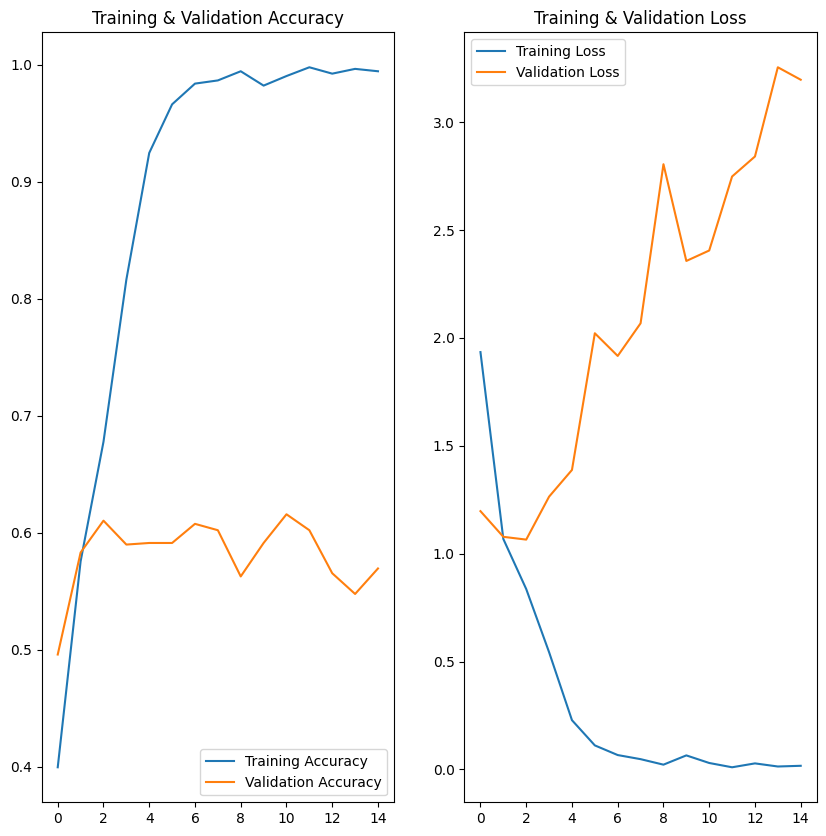

In [25]:
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(EPOCHS)
plt.figure(figsize=FIG_SIZE)

# Training & validation accuracy.
plt.subplot(1, 2, 1)
plt.plot(history.epoch, acc, label='Training Accuracy')
plt.plot(history.epoch, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

# Training & validation loss.
plt.subplot(1, 2, 2)
plt.plot(history.epoch, loss, label='Training Loss')
plt.plot(history.epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Training & Validation Loss')

plt.show()

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accracy between training and validation accuracy is noticeable -- a sign of [overfitting].

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples -- to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as [overfitting]. It means that the model will have a difficult time generalizing on a new dataset.

There are mulitple ways to fight overfitting in the training process. Here, we use *data augmentation* and add *dropout* to the model.

[overfitting]: https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

### Data Augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation][data augmentation] takes the apporach of generating additional training data from your existing examples by augmenting then using random transformations that yeild believable-looking images. This helps expose the model to more aspects of the data and generizlie better.

Data augmentation will be implemented using the following Keras preprocessing layers: [`tf.keras.layers.RandomFlip`], [`tf.keras.layers.RandomRotation`] and [`tf.keras.layers.RandomZoom`]. These can be included inside the model like other layers and run on the GPU.

[data augmentation]: https://www.tensorflow.org/tutorials/images/data_augmentation
[`tf.keras.layers.RandomFlip`]: https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip
[`tf.keras.layers.RandomRotation`]: https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation
[`tf.keras.layers.RandomZoom`]: https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom

In [26]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(
        'horizontal',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

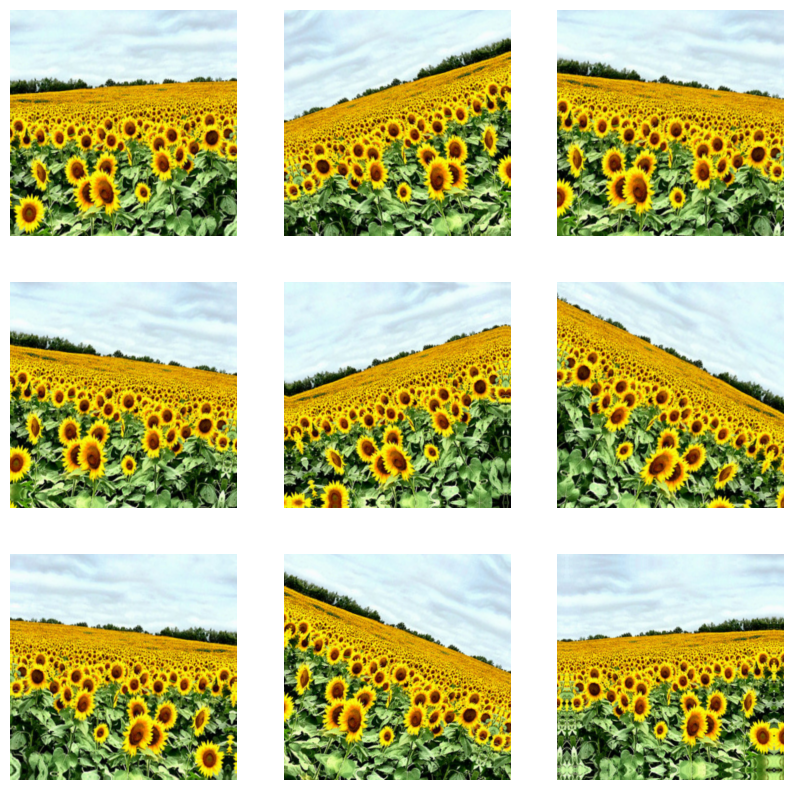

In [27]:
plt.figure(figsize=FIG_SIZE)

for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_imgs = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_imgs[0].numpy().astype('uint8'))
        plt.axis('off')

### Dropout

Another technique to reduce overfitting is to introduce [dropout][dropout] regularization to the ntetwork.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fraction number as its input value in the form such as 0.1, 0.2, 0.4 etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with [`tf.keras.layers.Dropout`] before training it using the augmented images:

[dropout]: https://developers.google.com/machine-learning/glossary#dropout_regularization
[`tf.keras.layers.Dropout`]: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

In [28]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1. / 255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, name='output')
])

### Compile & train the model

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 512, 512, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 512, 512, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 256, 256, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                  

In [31]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/15


2022-09-14 23:25:10.025519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 1.9829 - accuracy: 0.4097

2022-09-14 23:26:49.092532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 111s 1s/step - loss: 1.9829 - accuracy: 0.4097 - val_loss: 1.1631 - val_accuracy: 0.4837
Epoch 2/15
92/92 [==============================] - 116s 1s/step - loss: 1.0755 - accuracy: 0.5651 - val_loss: 0.9746 - val_accuracy: 0.6335
Epoch 3/15
92/92 [==============================] - 114s 1s/step - loss: 0.9778 - accuracy: 0.6087 - val_loss: 0.9562 - val_accuracy: 0.6417
Epoch 4/15
92/92 [==============================] - 110s 1s/step - loss: 0.8682 - accuracy: 0.6625 - val_loss: 0.9474 - val_accuracy: 0.6172
Epoch 5/15
92/92 [==============================] - 111s 1s/step - loss: 0.8100 - accuracy: 0.6907 - val_loss: 0.9434 - val_accuracy: 0.6362
Epoch 6/15
92/92 [==============================] - 112s 1s/step - loss: 0.7522 - accuracy: 0.7115 - val_loss: 0.8590 - val_accuracy: 0.6771
Epoch 7/15
92/92 [==============================] - 111s 1s/step - loss: 0.7087 - accuracy: 0.7275 - val_loss: 0.9446 - val_accuracy: 0.6485
Epoch 8/15
92/92 [======

### Visualizing training results

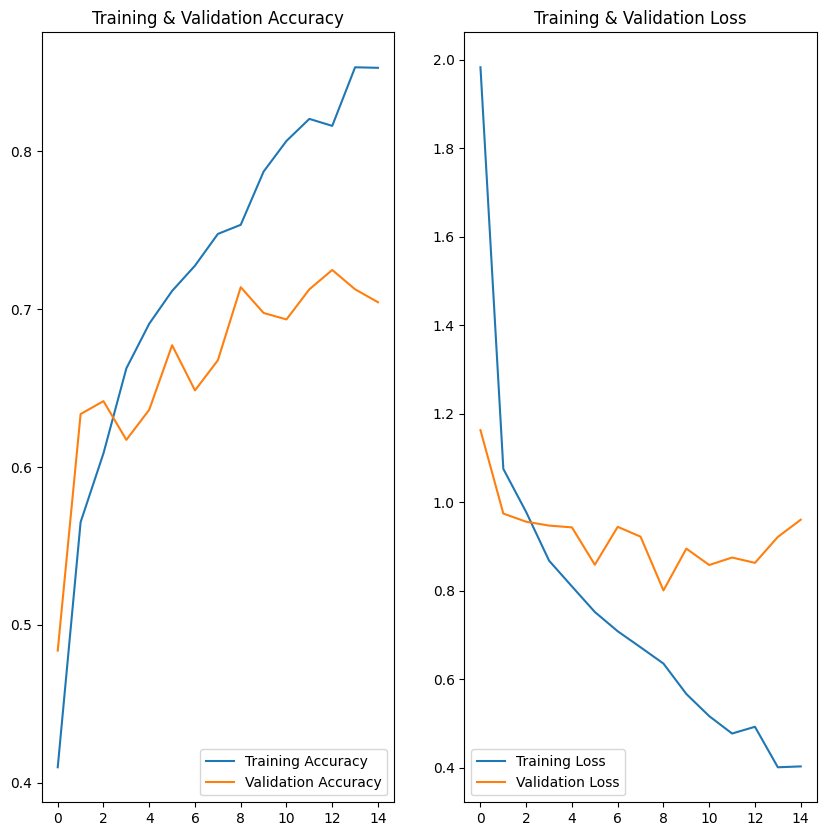

In [32]:
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(EPOCHS)
plt.figure(figsize=FIG_SIZE)

# Training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epoch_range, acc, label='Training Accuracy')
plt.plot(epoch_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

# Training & validation loss
plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label='Training Loss')
plt.plot(epoch_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training & Validation Loss')

plt.show()

## Predict on New Data

In [33]:
sunflower_path = tf.keras.utils.get_file(
    'Red_sunflower', origin=SUNFLOWER_URL
)

img = tf.keras.utils.load_img(
    sunflower_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)
img_arr = tf.keras.utils.img_to_array(img)
img_arr = tf.expand_dims(img_arr, 0)  # Create a batch.

predictions = model.predict(img_arr)
score = tf.nn.softmax(predictions[0])

print(f'This image is most likely to be {class_names[np.argmax(score)]}'
      f' with a {np.max(score):.02%} confidence')

2022-09-14 23:53:14.244052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 711ms/step
This image is most likely to be sunflowers with a 99.84% confidence


## Use TensorFlow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded & edge ddevices.

### Convert the Keras model to a TensorFlow Lite model

To use the trained model with on-device applications, first [convert it] to a smaller and more efficient model format called a [TensorFlow Lite] model.

In this example, take the trained Keras Sequential model and use [`tf.lite.TFLiteConverter.from_keras_model`] to generate a [TensorFlow Lite] model.

[convert it]: https://www.tensorflow.org/lite/models/convert
[TensorFlow Lite]: https://www.tensorflow.org/lite/
[`tf.lite.TFLiteConverter.from_keras_model`]: https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter#from_keras_model

In [35]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Create saved model directory.
os.makedirs(
    os.path.dirname(TF_LITE_MODEL_PATH),
    exist_ok=True
)

# Save the model.
with open(TF_LITE_MODEL_PATH, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/99/y3r4vtrx335gvk8f_0vp7ffw0000gn/T/tmpv9t4jehi/assets


INFO:tensorflow:Assets written to: /var/folders/99/y3r4vtrx335gvk8f_0vp7ffw0000gn/T/tmpv9t4jehi/assets
2022-09-14 23:54:23.927821: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-09-14 23:54:23.927836: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-09-14 23:54:23.927908: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/99/y3r4vtrx335gvk8f_0vp7ffw0000gn/T/tmpv9t4jehi
2022-09-14 23:54:23.930433: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-09-14 23:54:23.930439: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/99/y3r4vtrx335gvk8f_0vp7ffw0000gn/T/tmpv9t4jehi
2022-09-14 23:54:23.939167: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-09-14 23:54:24.139904: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

The TensorFlow Lite model you saved in previous step can contain several function signatures.
The Keras model converter API uses the default signature automatically.
Learn more about [TensorFlow Lite signatures].

[TensorFlow Lite signatures]: https://www.tensorflow.org/lite/guide/signatures

### Run the TensorFlow Lite model

You can access the TensorFlow Lite saved model signatures in Python via the [`tf.lite.Interpreter`] class.

Load the model with the `Interpreter`:

[`tf.lite.Interpreter`]: https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter

In [36]:
# Load the model with `Interpreter`.
interpreter = tf.lite.Interpreter(model_path=TF_LITE_MODEL_PATH)

In [37]:
# Print the signature from converted model.
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['output']}}

### Perform inference

In [38]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [39]:
predictions_lite = classify_lite(sequential_1_input=img_arr)['output']
score_lite = tf.nn.softmax(predictions_lite)

assert np.allclose(predictions, predictions_lite)

print(f'This image most likely belongs to {class_names[np.argmax(score_lite)]}'
      f' with a {np.max(score_lite):.02%} confidence')

This image most likely belongs to sunflowers with a 99.84% confidence
